In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import itertools
from astropy.io import fits
import scipy
import pickle
import pymaster as nmt
from planck_util import *

In [3]:
freqs = ['100', '143', '217']
splits = ['1', '2']
channels = [ 'TT', 'TE', 'EE' ]
result_dict = {}

ps = PlanckSpectra()

In [ ]:
%%time
for f1,f2 in itertools.product(freqs, repeat=2):
    for s1,s2 in itertools.product(splits, repeat=2):
        if not (( f1, f2, s1, s2 ) in result_dict):
            print( f1, f2, s1, s2 )
            Cb = ps.compute(f1, f2, s1, s2)
            result_dict[( f1, f2, s1, s2 )] = Cb

100 100 1 1


/home/zequnl/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


100 100 1 2
100 100 2 1
100 100 2 2
100 143 1 1
100 143 1 2
100 143 2 1
100 143 2 2
100 217 1 1
100 217 1 2
100 217 2 1


In [8]:
with open('Cb.pickle', 'wb') as handle:
    pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

---

In [10]:
with open('Cb.pickle', 'rb') as handle:
    Cb = pickle.load(handle)

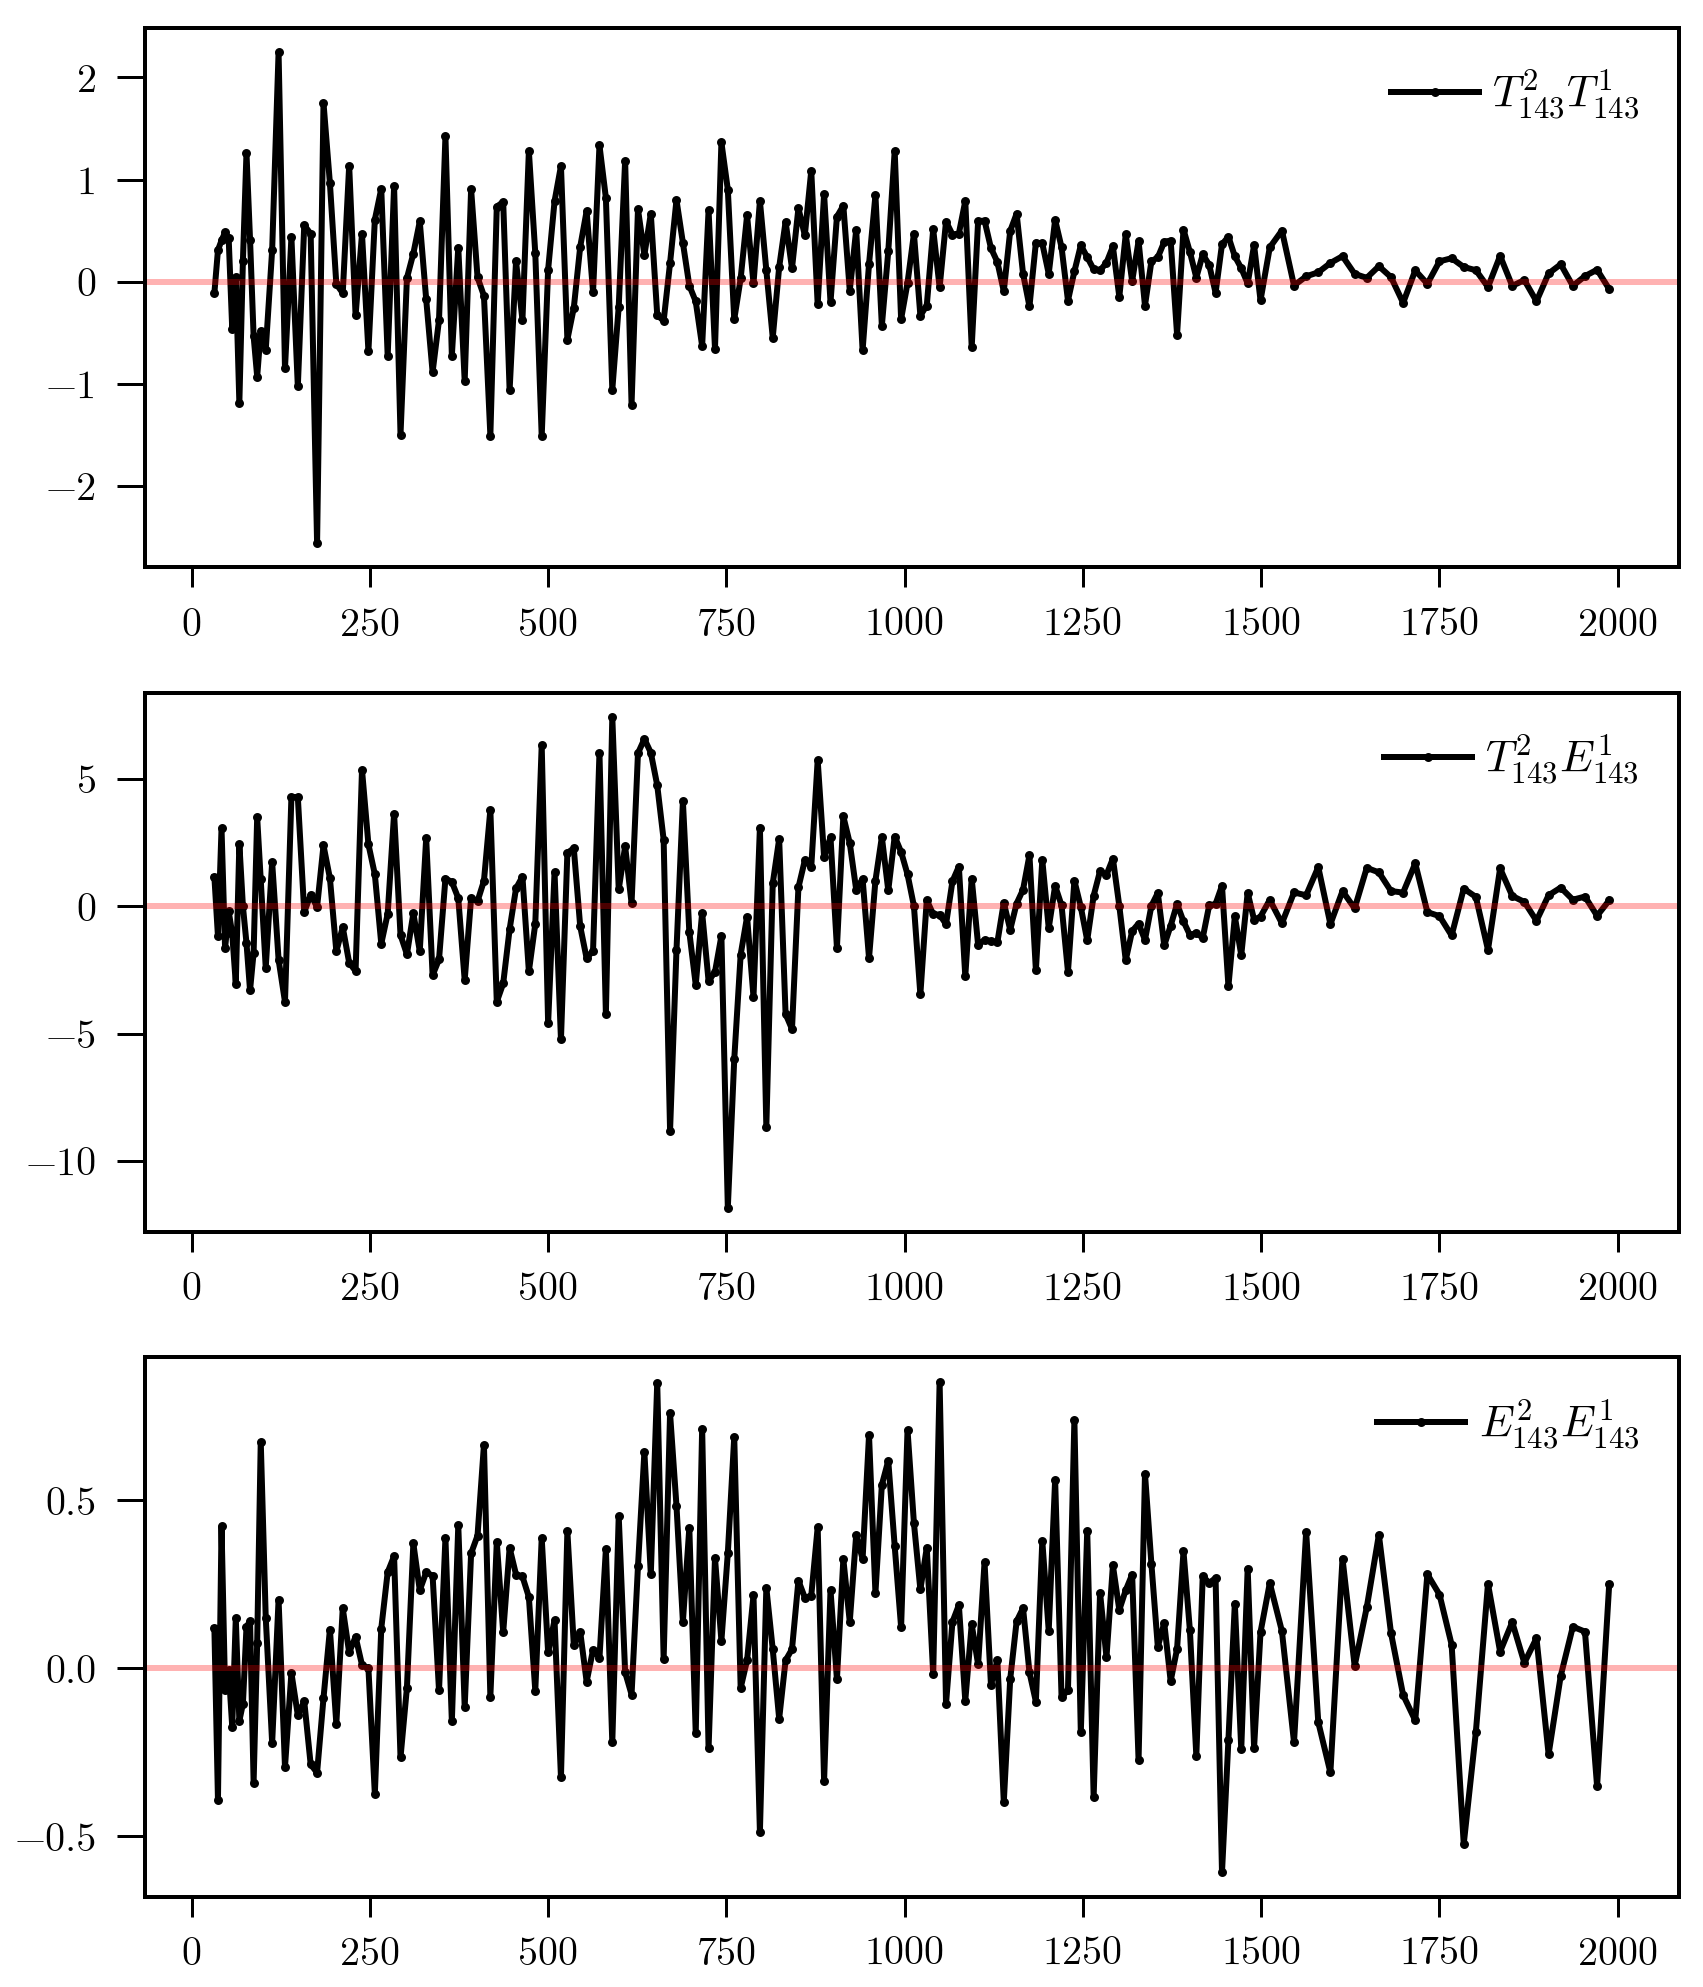

In [28]:

fig, axes = plt.subplots(3,1,figsize=(12,14))

f1, f2, s1, s2 = '143', '143', '2', '1'

for spec, ax in zip(['TT', 'TE', 'EE'], axes):
    lmin_,lmax_,l_ref,cl_ref,error_ref=np.loadtxt('planck_spectra/spectra_' + f'{spec}_{f1}x{f2}' + '.dat',unpack=True)
    dl_ref_fac = l_ref*(l_ref+1)/(2*np.pi)

    dl = np.interp(x=l_ref, xp=ps.lb, fp=Cb[f1, f2, s1, s2][spec] * 1e12) 
    ax.plot(l_ref, (dl - (cl_ref * dl_ref_fac)) / (error_ref * dl_ref_fac), 
            'k.-', 
            label=( '$' + spec[0] + '_{' + f1 + '}^{' + 
                   s1 + '}' + spec[1] + '_{' + f2 + '}^{' + s2 + '}$'))
    ax.axhline(0, color='red', alpha=0.3)
#     ax.set_ylim(-3,3)
    ax.legend()
    

fig.tight_layout()

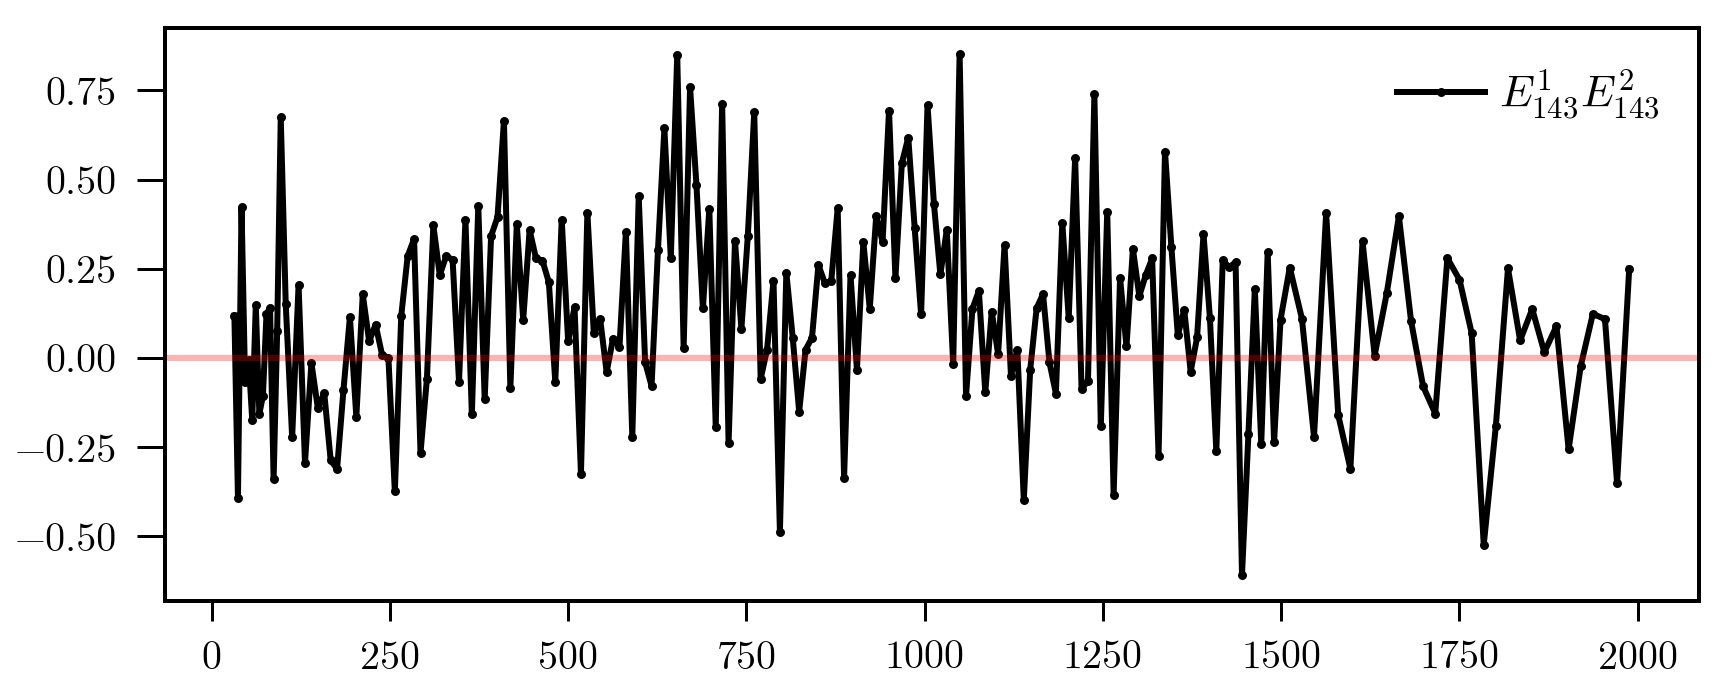

In [52]:

fig, axes = plt.subplots(1,1,figsize=(12,5))

f1, f2, s1, s2 = '143', '143', '1', '2'

for spec, ax in zip(['EE'], [axes]):
    lmin_,lmax_,l_ref,cl_ref,error_ref=np.loadtxt('planck_spectra/spectra_' + f'{spec}_{f1}x{f2}' + '.dat',unpack=True)
    dl_ref_fac = l_ref*(l_ref+1)/(2*np.pi)

    dl = np.interp(x=l_ref, xp=ps.lb, fp=Cb[f1, f2, s1, s2][spec] * 1e12) 
    ax.plot(l_ref, (dl - (cl_ref * dl_ref_fac)) / (error_ref * dl_ref_fac), 
            'k.-', 
            label=( '$' + spec[0] + '_{' + f1 + '}^{' + 
                   s1 + '}' + spec[1] + '_{' + f2 + '}^{' + s2 + '}$'))
    ax.axhline(0, color='red', alpha=0.3)
#     ax.set_ylim(-3,3)
    ax.legend()
    

fig.tight_layout()

In [29]:
import itertools

freqs = ['100', '143', '217']
splits = ['1', '2']
channels = [ 'TT', 'TE', 'EE' ]

ch_dict = dict(zip(channels, [[] for _ in channels])) 

for ch1, ch2 in channels:
    for f1,f2 in itertools.product(freqs, repeat=2):
        for s1,s2 in itertools.product(splits, repeat=2):
            auto_contains_noise = (f1 == f2 and s1 == s2)
            
            splitkey = (ch1, f1, s1, ch2, f2, s2)
            flipped_splitkey = (ch2, f2, s2, ch1, f1, s1)
            if not ((flipped_splitkey in ch_dict[ch1 + ch2] )
                    or auto_contains_noise):
                ch_dict[ch1 + ch2].append(splitkey)

In [35]:
[ X_ + f1_ + ',' + s1_ +' '+ Y_ + f2_ + ',' + s2_  
 for X_, f1_, s1_, Y_, f2_, s2_ in ch_dict['TT']]

['T100,1 T100,2',
 'T100,1 T143,1',
 'T100,1 T143,2',
 'T100,2 T143,1',
 'T100,2 T143,2',
 'T100,1 T217,1',
 'T100,1 T217,2',
 'T100,2 T217,1',
 'T100,2 T217,2',
 'T143,1 T143,2',
 'T143,1 T217,1',
 'T143,1 T217,2',
 'T143,2 T217,1',
 'T143,2 T217,2',
 'T217,1 T217,2']

In [39]:
veclist = []

for f1,f2 in itertools.combinations_with_replacement(freqs, r=2):
    print(f1, f2, '---------')
    
    Cb_temp = []
    for X_, f1_, s1_, Y_, f2_, s2_ in ch_dict['TT']:
        if f1_ == f1 and f2_ == f2:
            print(X_ + f1_ + ',' + s1_ +' '+ Y_ + f2_ + ',' + s2_ )
            Cb_temp.append(Cb[f1_,f2_,s1_,s2_]['TT'])
            
    veclist.append( np.hstack(Cb_temp) )

100 100 ---------
T100,1 T100,2
100 143 ---------
T100,1 T143,1
T100,1 T143,2
T100,2 T143,1
T100,2 T143,2
100 217 ---------
T100,1 T217,1
T100,1 T217,2
T100,2 T217,1
T100,2 T217,2
143 143 ---------
T143,1 T143,2
143 217 ---------
T143,1 T217,1
T143,1 T217,2
T143,2 T217,1
T143,2 T217,2
217 217 ---------
T217,1 T217,2


(-1e-09, 7e-09)

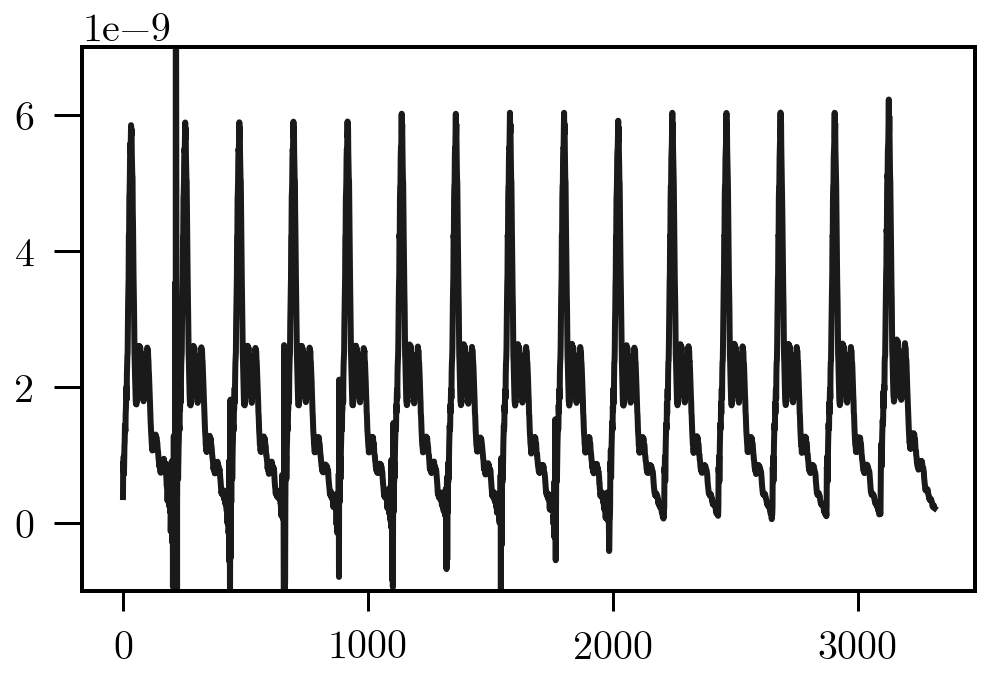

In [44]:
plt.figure(figsize=(8,5))
plt.plot( np.hstack(veclist) )
plt.ylim(-1e-9,0.7e-8)